# Regression on the deer data

**Goal:** In this notebook you will work with TFP. You will set up different regression models that are able to output different conditional probability distribution. You will define all models with Keras and the Tensorflow probability framework and optimize the negative log likelihood (NLL). You compare the performace of all regression models on the test dataset.  


**Usage:** This notebook should be a case study that you can do by yourself. Try to solve the exercises and then look at the solution and compare your results.

**Dataset:** You work with a dataset that describes deer related car accidents in the years 2002 until 2011 on roads in Bavaria, Germany. It counts the number of deers killed during 30-minute periods anywhere in Bavaria. This dataset has been used previously for the analysis of count data in the statistics literature, and is originally from https://zenodo.org/record/17179. 

**Content:**
* Load and split the dataset 
* Fit a linear regression model in keras and compute the minimal NLL with the optimal $\sigma$
* Fit a poisson regression model in keras and TFP
* Fit a poisson regression model with hidden layers in keras and TFP
* Fit a zero-inflated poisson regression model im keras and TFP
* Fit a zero-inflated poisson regression model with hidden layers in keras and TFP
* Fit a mixture model regression model in keras and TFP
* Fit a mixture model regression model with hidden layers in keras and TFP
* Compare the different models based on the NLL loss on the test dataset

***Hint: Use the previous notebooks form this chapter and the one before as help and reference when you try to solve the exercises***  
| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_06/nb_ch06_02.ipynb)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import scipy.stats as ss
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential
from typing import *

tfb = tfp.bijectors
tfd = tfp.distributions
data_path = os.path.join(os.path.dirname(os.getcwd()), "data")

In [2]:
df_train = pd.read_feather(os.path.join(data_path, "deer_train.feather"))
df_test = pd.read_feather(os.path.join(data_path, "deer_test.feather"))
data = pd.concat([df_train.assign(is_test=0), df_test.assign(is_test=1)], axis=0, ignore_index=True)
print(data.info())
print(data["is_test"].value_counts())
data[:5]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175296 entries, 0 to 175295
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype   
---  ------   --------------   -----   
 0   wild     175296 non-null  int32   
 1   year     175296 non-null  float64 
 2   time     175296 non-null  float64 
 3   daytime  175296 non-null  category
 4   weekday  175296 non-null  category
 5   is_test  175296 non-null  int64   
dtypes: category(2), float64(2), int32(1), int64(1)
memory usage: 5.0 MB
None
0    140256
1     35040
Name: is_test, dtype: int64


,wild,year,time,daytime,weekday,is_test
0,0,2002.0,0.000000,night.am,Sunday,0
1,0,2002.0,0.020833,night.am,Sunday,0
2,0,2002.0,0.041667,night.am,Sunday,0
3,1,2002.0,0.062500,night.am,Sunday,0
4,3,2002.0,0.083333,night.am,Sunday,0


In [3]:
print(data["daytime"].unique())
print(data["weekday"].unique())

['night.am', 'pre.sunrise.am', 'post.sunrise.am', 'day.am', 'day.pm', 'pre.sunset.pm', 'post.sunset.pm', 'night.pm']
Categories (8, object): ['day.am', 'night.am', 'pre.sunrise.am', 'post.sunrise.am', 'day.pm', 'night.pm', 'pre.sunset.pm', 'post.sunset.pm']
['Sunday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Monday', 'Tuesday']
Categories (7, object): ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


In [4]:
label = "wild"
features = ["time", "daytime", "weekday"]
train_cond = data["is_test"] == 0

data["time"] /= (df_train["time"].max() + 1 / 48)
data[label] = data[label].astype("float32")

y_train = data.loc[train_cond, label].values
y_test = data.loc[~train_cond, label].values

X_train = pd.get_dummies(data.loc[train_cond, features]).values
X_test = pd.get_dummies(data.loc[~train_cond, features]).values
del data, df_train, df_test

In [5]:
X_train.shape, X_test.shape

((140256, 16), (35040, 16))

Let's look at the distribution of the target variable: the number of deers killed during that 30-minute period. As you can see the distribution is very skewed. Gor most of the time the nummber of deers killed by a car is, as you would expect, zero. On the other hand you can see that there were two 30-minute periods where 37 and 38 deers died! 

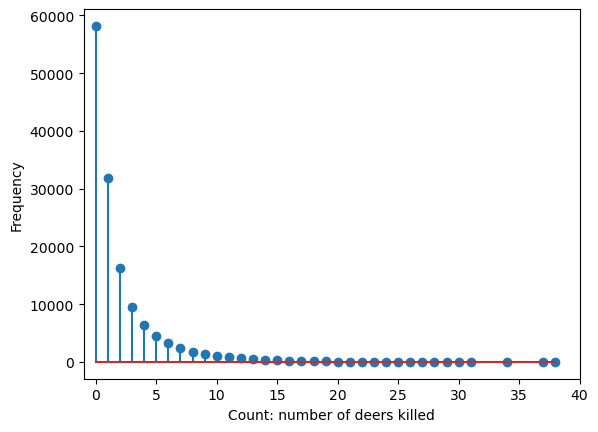

In [6]:
vals, counts = np.unique(y_train, return_counts=True)
plt.stem(vals, counts)
plt.xlabel('Count: number of deers killed')
plt.ylabel('Frequency')
plt.xlim(-1,40)
plt.show()

### Fitting and comparing different regression models on count data

*Exercise :     
Fit a linear regression model in keras and compute the minimal NLL with the optimal $\sigma$  
Fit a poisson regression model in keras and TFP  
Fit a poisson regression model with hidden layers in keras and TFP  
Fit a zero-inflated poisson regression model im keras and TFP  
Fit a zero-inflated poisson regression model with hidden layers in keras and TFP  
Fit a mixture model regression model in keras and TFP  
Fit a mixture model regression model with hidden layers in keras and TFP*  

*Compare the different models based on the NLL loss on the test dataset*

## Linear regression

In this section you do a standard linear regression in keras and optimize the mean squared error. Afterwards, you can claculate the optimal constant sigma by hand and compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period.

In [7]:
model_lr = Sequential(name="linear_regression") 
model_lr.add(Dense(1, input_dim=(X_train.shape[1]), activation='linear')) 
model_lr.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.01))
model_lr.summary()

Model: "linear_regression"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 17        
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


2022-10-18 16:44:22.599413: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
hist_lr = model_lr.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

2022-10-18 16:44:26.893978: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
4383/4383 [==============================] - 2s 457us/step - loss: 6.6318 - val_loss: 8.3650
Epoch 2/10
4383/4383 [==============================] - 2s 527us/step - loss: 6.5353 - val_loss: 8.3384
Epoch 3/10
4383/4383 [==============================] - 2s 434us/step - loss: 6.5365 - val_loss: 8.3225
Epoch 4/10
4383/4383 [==============================] - 2s 446us/step - loss: 6.5361 - val_loss: 8.3512
Epoch 5/10
4383/4383 [==============================] - 3s 627us/step - loss: 6.5363 - val_loss: 8.3301
Epoch 6/10
4383/4383 [==============================] - 2s 454us/step - loss: 6.5368 - val_loss: 8.3842
Epoch 7/10
4383/4383 [==============================] - 2s 430us/step - loss: 6.5376 - val_loss: 8.3959
Epoch 8/10
4383/4383 [==============================] - 2s 430us/step - loss: 6.5363 - val_loss: 8.3619
Epoch 9/10
4383/4383 [==============================] - 2s 435us/step - loss: 6.5373 - val_loss: 8.3378
Epoch 10/10
4383/4383 [==============================] - 2s 460u

In [28]:
def get_optimal_sigma(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    n = len(y_true)
    return np.sqrt(np.sum((y_true - y_pred) ** 2) / (n - 2))


def nll(y_true: np.ndarray, y_pred: np.ndarray, sigma: float) -> float:
    return -ss.norm(y_true, sigma).logpdf(y_pred).mean()

In [70]:
# Calculation of the the optimal sigma 
y_train_pred = model_lr.predict(X_train, batch_size=128).flatten()
sigma_hat = get_optimal_sigma(y_train, y_train_pred)
print("Estimated standard deviation: ", sigma_hat)

y_test_pred = model_lr.predict(X_test, batch_size=128).flatten()
print("NLL on train: ", nll(y_train, y_train_pred, sigma_hat))
print("NLL on test: ", nll(y_test, y_test_pred, sigma_hat))

Estimated standard deviation:  2.5563554336089114
NLL on train:  2.357513982259167
NLL on test:  2.4983433644093123


In [68]:
def plot_pred(y_true: np.ndarray, y_pred: np.ndarray, lower: np.ndarray, upper: np.ndarray):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_pred, y_true, alpha=0.3)
    sort_order = np.argsort(y_pred)
    plt.plot(y_pred[sort_order], y_pred[sort_order], c="black")
    plt.plot(y_pred[sort_order], lower[sort_order], linestyle="--", c="black")
    plt.plot(y_pred[sort_order], upper[sort_order], linestyle="--", c="black")
    plt.title('Comparison on the testset')
    plt.xlabel('predicted average of deers killed')
    plt.ylabel('observed number of deers killed')

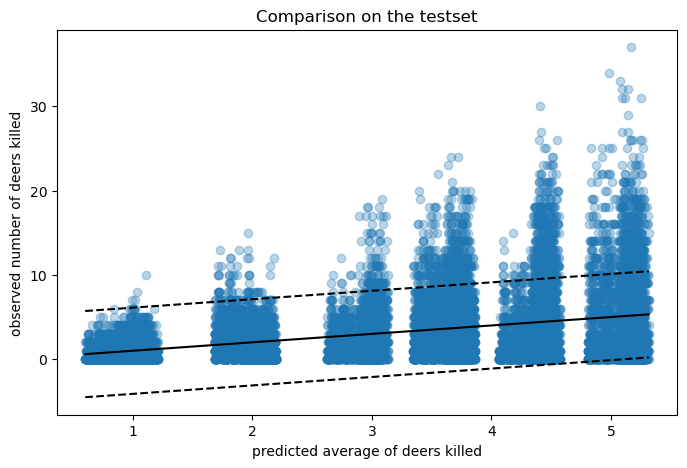

In [71]:
plot_pred(y_test, y_test_pred, y_test_pred - 2 * sigma_hat, y_test_pred + 2 * sigma_hat)

## Poisson Regression

In this section you do a poisson regression with keras and TFP and optimize the NLL. Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. Note that a poisson regression is better suited than a linear regression because we are dealing with count data in this problem.

In [48]:
inputs = Input(shape=(X_train.shape[1],))  
rate = Dense(1, activation="exponential")(inputs) 
p_y = tfp.layers.DistributionLambda(lambda t: tfd.Poisson(rate=t, force_probs_to_zero_outside_support=True))(rate) 
model_p = Model(inputs=inputs, outputs=p_y, name="Poisson") 


def NLL(y, dist): 
  return -dist.log_prob(y)


model_p.compile(Adam(learning_rate=0.01), loss=NLL)
model_p.summary()

Model: "Poisson"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
_________________________________________________________________
distribution_lambda_1 (Distr multiple                  0         
Total params: 17
Trainable params: 17
Non-trainable params: 0
_________________________________________________________________


In [49]:
hist_p = model_p.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
4383/4383 [==============================] - 3s 537us/step - loss: 1.9298 - val_loss: 2.0999
Epoch 2/10
4383/4383 [==============================] - 2s 502us/step - loss: 1.9189 - val_loss: 2.0816
Epoch 3/10
4383/4383 [==============================] - 2s 503us/step - loss: 1.9188 - val_loss: 2.0810
Epoch 4/10
4383/4383 [==============================] - 2s 506us/step - loss: 1.9184 - val_loss: 2.0790
Epoch 5/10
4383/4383 [==============================] - 2s 510us/step - loss: 1.9188 - val_loss: 2.0795
Epoch 6/10
4383/4383 [==============================] - 2s 505us/step - loss: 1.9184 - val_loss: 2.1088
Epoch 7/10
4383/4383 [==============================] - 2s 507us/step - loss: 1.9186 - val_loss: 2.0830
Epoch 8/10
4383/4383 [==============================] - 2s 501us/step - loss: 1.9183 - val_loss: 2.0774
Epoch 9/10
4383/4383 [==============================] - 2s 500us/step - loss: 1.9186 - val_loss: 2.1005
Epoch 10/10
4383/4383 [==============================] - 2s 502u

In [56]:
NLL_train = model_p.evaluate(X_train, y_train,verbose=0) 
NLL_test = model_p.evaluate(X_test, y_test,verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.916863203048706
NLL on test: 2.0977964401245117


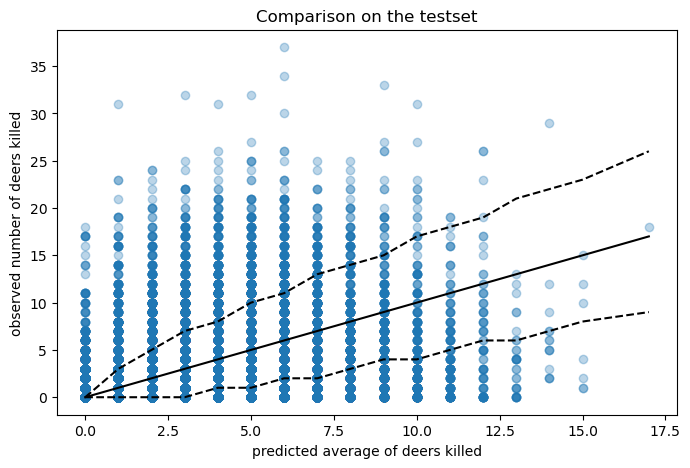

In [73]:
y_test_pred = model_p.predict(X_test, batch_size=128).flatten()
lower = ss.poisson.ppf(0.025, y_test_pred)
upper = ss.poisson.ppf(0.975, y_test_pred)

plot_pred(y_test, y_test_pred, lower, upper)

## Poisson Regression with hidden layers

In this section you do a poisson regression with keras and TFP and optimize the NLL. This time we add some hidden layers in between. Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. Note that a poisson regression is better suited than a linear regression because we are dealing with count data in this problem.

In [74]:
inputs = Input(shape=(X_train.shape[1],))  
x = Dense(100, activation="relu")(inputs) 
x = Dense(100, activation="relu")(x) 
x = Dense(10, activation="relu")(x) 
rate = Dense(1, activation="exponential")(x) 
p_y = tfp.layers.DistributionLambda(lambda t: tfd.Poisson(rate=t, force_probs_to_zero_outside_support=True))(rate) 
model_p_h = Model(inputs=inputs, outputs=p_y, name="Poisson_hidden") 

model_p_h.compile(Adam(learning_rate=0.01), loss=NLL)
model_p_h.summary()

Model: "Poisson_hidden"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               1700      
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
_________________________________________________________________
distribution_lambda_2 (Distr multiple                  0         
Total params: 12,821
Trainable params: 12,821
Non-trainable params: 0
________________________________________________

In [75]:
hist_p_h = model_p_h.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
4383/4383 [==============================] - 4s 877us/step - loss: 1.9067 - val_loss: 2.0515
Epoch 2/10
4383/4383 [==============================] - 4s 874us/step - loss: 1.8940 - val_loss: 2.0470
Epoch 3/10
4383/4383 [==============================] - 4s 878us/step - loss: 1.8919 - val_loss: 2.0466
Epoch 4/10
4383/4383 [==============================] - 4s 868us/step - loss: 1.8929 - val_loss: 2.0475
Epoch 5/10
4383/4383 [==============================] - 4s 895us/step - loss: 1.8906 - val_loss: 2.0506
Epoch 6/10
4383/4383 [==============================] - 4s 897us/step - loss: 1.8906 - val_loss: 2.0358
Epoch 7/10
4383/4383 [==============================] - 4s 894us/step - loss: 1.8906 - val_loss: 2.0885
Epoch 8/10
4383/4383 [==============================] - 4s 887us/step - loss: 1.8907 - val_loss: 2.1166
Epoch 9/10
4383/4383 [==============================] - 4s 895us/step - loss: 1.8911 - val_loss: 2.0427
Epoch 10/10
4383/4383 [==============================] - 4s 883u

In [76]:
NLL_train = model_p_h.evaluate(X_train, y_train, verbose=0) 
NLL_test = model_p_h.evaluate(X_test, y_test, verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 1.8870538473129272
NLL on test: 2.0407216548919678


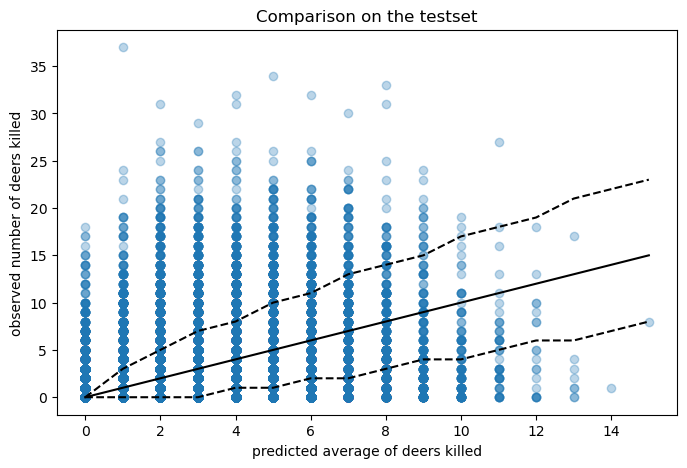

In [77]:
y_test_pred = model_p_h.predict(X_test, batch_size=128).flatten()
lower = ss.poisson.ppf(0.025, y_test_pred)
upper = ss.poisson.ppf(0.975, y_test_pred)

plot_pred(y_test, y_test_pred, lower, upper)

## Zero inflated Poisson Regression

In this section you do a zero infalted poisson regression with keras and TFP and optimize the NLL. A zero inflated poisson regression should be better suited because for most of the time the number of killed deer in a 30-minutes period is zero. You define ZIP distribution in TFP with the two parameters :
* rate: which defines the rate $\lambda$ of a Poisson process
* s: the probability to pick Poisson process (accordingly the zero-generating process is picked with probability 1-s)

Afterwards, you can compare the NLL for the train and testset. Finally you plot the predicted vs the true labels of the number of deers killed in a 30-minutes period. 

In [113]:
inputs = Input(shape=(X_train.shape[1],))  
out = Dense(2)(inputs)

def zero_inf(out):
    rate = K.exp(out[:, 0])
    s = K.sigmoid(out[:, 1:2])
    probs = tf.concat([1 - s, s], axis=1)
    return tfd.Mixture(
        cat=tfd.Categorical(probs=probs), 
        components=[tfd.Deterministic(loc=K.zeros_like(rate)), 
                    tfd.Poisson(rate=rate, force_probs_to_zero_outside_support=True)])

dist = tfp.layers.DistributionLambda(zero_inf)(out)
model_zip = Model(inputs=inputs, outputs=dist, name="ZIPossion")

model_zip.compile(Adam(learning_rate=0.01), loss=NLL)
model_zip.summary()

Model: "ZIPossion"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 16)]              0         
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 34        
_________________________________________________________________
distribution_lambda_8 (Distr multiple                  0         
Total params: 34
Trainable params: 34
Non-trainable params: 0
_________________________________________________________________


In [114]:
hist_zip = model_zip.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, verbose=1)

Epoch 1/10
4383/4383 [==============================] - 4s 720us/step - loss: 2.1782 - val_loss: 2.3658
Epoch 2/10
4383/4383 [==============================] - 3s 683us/step - loss: 2.1676 - val_loss: 2.3810
Epoch 3/10
4383/4383 [==============================] - 3s 680us/step - loss: 2.1672 - val_loss: 2.3935
Epoch 4/10
4383/4383 [==============================] - 3s 685us/step - loss: 2.1672 - val_loss: 2.4224
Epoch 5/10
4383/4383 [==============================] - 3s 698us/step - loss: 2.1674 - val_loss: 2.4026
Epoch 6/10
4383/4383 [==============================] - 3s 722us/step - loss: 2.1681 - val_loss: 2.3694
Epoch 7/10
4383/4383 [==============================] - 3s 676us/step - loss: 2.1675 - val_loss: 2.3716
Epoch 8/10
4383/4383 [==============================] - 3s 682us/step - loss: 2.1673 - val_loss: 2.3701
Epoch 9/10
4383/4383 [==============================] - 3s 678us/step - loss: 2.1679 - val_loss: 2.3669
Epoch 10/10
4383/4383 [==============================] - 3s 677u

In [87]:
NLL_train = model_zip.evaluate(X_train, y_train, verbose=0) 
NLL_test = model_zip.evaluate(X_test, y_test, verbose=0) 

print('NLL on training:', NLL_train)
print('NLL on test:', NLL_test)

NLL on training: 2.1611990928649902
NLL on test: 2.371340751647949


100%|█████████████████████████████████████████████████████████████████████████████| 3504/3504 [01:06<00:00, 52.30it/s]


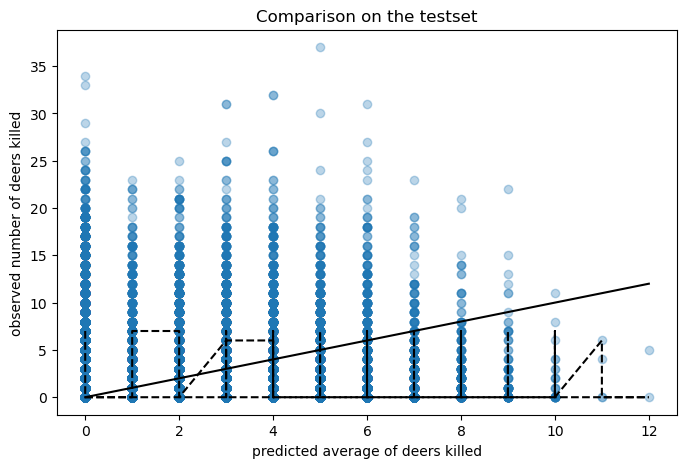

In [129]:
y_test_pred = model_zip.predict(X_test)
upper = np.zeros_like(y_test)
lower = np.zeros_like(y_test)
batch_size = 10

for i in tqdm(range(0, len(X_test), batch_size)):
    slice_ = slice(i * batch_size, (i + 1) * batch_size)
    samples = model_zip(X_test[slice_]).sample(5000).numpy().T
    upper[slice_] = np.quantile(samples, 0.975, axis=1)
    lower[slice_] = np.quantile(samples, 0.025, axis=1)

plot_pred(y_test, y_test_pred, lower, upper)

In [130]:
model_zip(X_test).mean()

<tf.Tensor: shape=(35040,), dtype=float32, numpy=
array([1.9175032, 1.9175034, 1.9175035, ..., 1.932295 , 1.9322951,
       1.9322952], dtype=float32)>

In [118]:
y_test_pred2

array([1.9175032, 1.9175034, 1.9175035, ..., 1.932295 , 1.9322951,
       1.9322952], dtype=float32)

In [131]:
pred = model_zip(X_test).mean().numpy()

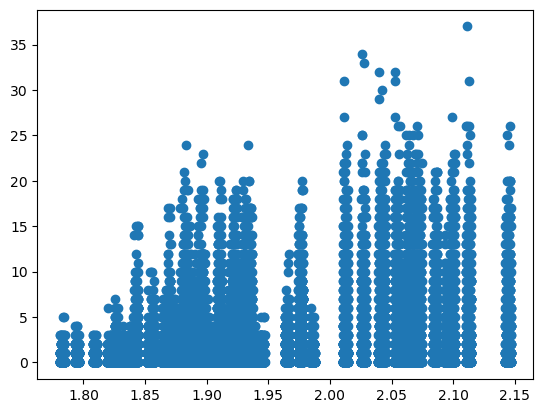

In [132]:
plt.scatter(pred, y_test)